In [1]:
'''
ManGo - Machine Gnostics Library
Copyright (C) 2025  ManGo Team

This work is licensed under the terms of the GNU General Public License version 3.0.
'''

import numpy as np

class GnosticsCharacteristics:
    """
    A class containing internal functions for Machine Gnostics (MG) calculations.

    Notes
    -----
    The class takes an input matrix R = Z / Z0, where:
        - Z  : Observed data
        - Z0 : Estimated value

    Internally, it computes:
        - q  = R
        - q1 = 1 / R  (with protection against division by zero)

    The internal methods (_fi, _fj, _hi, _hj) operate on q and q1 to calculate
    various gnostic characteristics.

    Methods
    -------
    _fi(q, q1)
        Calculates the estimation weight.

    _fj(q, q1)
        Calculates the quantification weight.

    _hi(q, q1)
        Calculates the estimation relevance.

    _hj(q, q1)
        Calculates the quantification relevance.
    """

    def __init__(self, R: np.ndarray):
        """
        Initializes the GnosticsCharacteristics class.

        Parameters
        ----------
        R : np.ndarray
            The input matrix for the gnostics calculations (R = Z / Z0).
        """
        max_eps = np.finfo(float).max
        min_eps = np.finfo(float).eps
        self.R = R
        self.q = R
        # avoid division by zero
        self.q1 = np.where(np.abs(R) > min_eps, 1 / R, max_eps)

    def _fi(self, q=None, q1=None):
        """
        Calculates the estimation weight.

        Parameters
        ----------
        q : np.ndarray or float
        q1 : np.ndarray or float

        Returns
        -------
        f : np.ndarray or float
        """
        if q is None:
            q = self.q
        if q1 is None:
            q1 = self.q1

        q = np.asarray(q)
        q1 = np.asarray(q1)
        if q.shape != q1.shape:
            raise ValueError("q and q1 must have the same shape")
        f = 2 / (q + q1)
        return f

    def _fj(self, q=None, q1=None):
        """
        Calculates the quantification weight.

        Parameters
        ----------
        q : np.ndarray or float
        q1 : np.ndarray or float

        Returns
        -------
        f : np.ndarray or float
        """
        if q is None:
            q = self.q
        if q1 is None:
            q1 = self.q1

        q = np.asarray(q)
        q1 = np.asarray(q1)
        if q.shape != q1.shape:
            raise ValueError("q and q1 must have the same shape")
        f = (q + q1) / 2
        return f

    def _hi(self, q=None, q1=None):
        """
        Calculates the estimation relevance.

        Parameters
        ----------
        q : np.ndarray or float
        q1 : np.ndarray or float

        Returns
        -------
        h : np.ndarray or float
        """
        if q is None:
            q = self.q
        if q1 is None:
            q1 = self.q1
        q = np.asarray(q)
        q1 = np.asarray(q1)
        if q.shape != q1.shape:
            raise ValueError("q and q1 must have the same shape")
        h = (q - q1) / (q + q1)
        return h

    def _hj(self, q=None, q1=None):
        """
        Calculates the quantification relevance.

        Parameters
        ----------
        q : np.ndarray or float
        q1 : np.ndarray or float

        Returns
        -------
        h : np.ndarray or float
        """
        if q is None:
            q = self.q
        if q1 is None:
            q1 = self.q1
            
        q = np.asarray(q)
        q1 = np.asarray(q1)
        if q.shape != q1.shape:
            raise ValueError("q and q1 must have the same shape")
        h = (q - q1) / 2
        return h
    
    def _rentropy(self, fi, fj):
        """
        Calculates the residual entropy.

        Parameters
        ----------
        fi : np.ndarray or float
            Estimation weight.
        fj : np.ndarray or float
            Quantification weight.

        Returns
        -------
        entropy : np.ndarray or float
            Relative entropy.
        """
        fi = np.asarray(fi)
        fj = np.asarray(fj)
        if fi.shape != fj.shape:
            raise ValueError("fi and fj must have the same shape")
        entropy = fj - fi
        if entropy < 0: #means something is wrong
            raise ValueError("Entropy cannot be negative")
        return entropy


In [3]:
'''
ManGo - Machine Gnostics Library
Copyright (C) 2025  ManGo Team

This work is licensed under the terms of the GNU General Public License version 3.0.
'''

import numpy as np
# from src.magcal.characteristics import GnosticsCharacteristics

class GnosticRobustRegression(GnosticsCharacteristics):
    """
    A class to perform Gnostic Robust Regression based on the iterative formula
    described in Equation 19.2 of the provided reference.
    """

    def __init__(self, X, y, criterion="E1", max_iter=100, tol=1e-6, degree=1, gc_history=False, verbose=False):
            """
            Initialize the regression model.

            Parameters:
            - X: np.ndarray, shape (n_samples, n_features)
                The input feature matrix.
            - y: np.ndarray, shape (n_samples,)
                The target vector.
            - criterion: str
                The gnostic criterion to use (e.g., "Q1", "E1", "Q2", etc.).
            - max_iter: int
                Maximum number of iterations for the regression.
            - tol: float
                Tolerance for convergence.
            - degree: int
                The degree of the polynomial regression. Default is 1 (linear regression).
            - gc_history: bool
                If True, records the history of gnostic characteristics (hi, hj, fi, fj).
            - verbose: bool
                If True, prints additional information during fitting.
            """
            # data checking
            if len(X.shape) != 2:
                raise ValueError("X must be a 2D array.")
            if len(y.shape) != 1:
                raise ValueError("y must be a 1D array.")
            if X.shape[0] != y.shape[0]:
                raise ValueError("Number of samples in X and y must match.")
            
            self.degree = degree
            self.X = self._expand_features(X, degree)
            self.y = y
            self.criterion = criterion
            self.max_iter = max_iter
            self.tol = tol
            self.gc_history = gc_history
            self.weights = np.ones(self.X.shape[0])  # Initialize weights to 1
            self.coefficients = None
            self.history = {"hi": [], "hj": [], "fi": [], "fj": [], "re": []} if gc_history else None
            self.verbose = verbose

    def _compute_filtering_weight(self, residuals):
        """
        Compute the filtering weights based on the selected gnostic criterion.

        Parameters:
        - residuals: np.ndarray, shape (n_samples,)
            The residuals of the current iteration.

        Returns:
        - weights: np.ndarray, shape (n_samples,)
            The updated filtering weights.
        """
        # compute q and q1
        eps_max = np.finfo(float).max
        eps_min = np.finfo(float).eps
        # y0 - the initial estimate
        # Avoid division by zero or invalid values
        y0 = np.dot(self.X, self.coefficients)
        y0 = np.where(np.abs(y0) < eps_min, eps_min, y0)  # Replace near-zero values with eps_min

        q = self.y / y0
        q = np.where(np.abs(q) < eps_min, eps_min, q)  # Replace near-zero values with eps_min
        q = np.where(np.abs(q) > eps_max, eps_max, q)  # Cap values exceeding eps_max

        q1 = 1 / q
        q1 = np.where(np.abs(q1) < eps_min, eps_min, q1)  # Replace near-zero values with eps_min
        q1 = np.where(np.abs(q1) > eps_max, eps_max, q1)  # Cap values exceeding eps_max
        
        # gnostic characteristics
        h_q = self._fi(q, q1)
        f_q = 1 / (h_q + eps_min)  # Avoid division by zero
        h_e = self._hi(q, q1)
        f_e = 1 / (h_e + eps_min)

        if self.criterion == "Q1":
            return f_q
        elif self.criterion == "E1":
            return f_e ** 2
        elif self.criterion == "Q2":
            return np.ones_like(residuals)  # Constant weight for Q2
        elif self.criterion == "E2":
            return f_e
        elif self.criterion == "Q3":
            return 1 / np.sqrt(f_q)
        elif self.criterion == "E3":
            return np.sqrt(f_e)
        else:
            raise ValueError(f"Unknown criterion: {self.criterion}")

    def _update_weights(self, residuals):
        """
        Update the weights based on the residuals and the filtering function.

        Parameters:
        - residuals: np.ndarray, shape (n_samples,)
            The residuals of the current iteration.
        """
        self.weights = self._compute_filtering_weight(residuals)
    
    def _expand_features(self, X, degree):
        """
        Expand the input feature matrix to include polynomial terms up to the specified degree.

        Parameters:
        - X: np.ndarray, shape (n_samples, n_features)
            The input feature matrix.
        - degree: int
            The degree of the polynomial regression.

        Returns:
        - X_expanded: np.ndarray, shape (n_samples, n_expanded_features)
            The expanded feature matrix with polynomial terms.
        """
        X_expanded = X
        for d in range(2, degree + 1):
            X_expanded = np.hstack([X_expanded, X ** d])
        return X_expanded

    def fit(self):
        """
        Fit the regression model using the iterative weighted least squares approach.
        """
        n_samples, n_features = self.X.shape
        X_weighted = self.X.copy()
        y_weighted = self.y.copy()

        # Initialize coefficients
        self.coefficients = np.zeros(n_features)

        for iteration in range(self.max_iter):
            # Compute residuals
            residuals = self.y - np.dot(self.X, self.coefficients)

            # Update weights
            self._update_weights(residuals)

            # Apply weights to the design matrix and target vector
            W = np.sqrt(self.weights)[:, np.newaxis]
            X_weighted = W * self.X
            y_weighted = W.flatten() * self.y

            # Check for NaNs or infinities
            if not np.isfinite(X_weighted).all() or not np.isfinite(y_weighted).all():
                raise ValueError("NaN or infinity detected in weighted matrices. Check your data or weights.")

            # Solve the weighted least squares problem
            new_coefficients = np.linalg.lstsq(X_weighted, y_weighted, rcond=None)[0]

            # Check for convergence
            if np.linalg.norm(new_coefficients - self.coefficients) < self.tol:
                if self.verbose:
                    print(f"Converged in {iteration + 1} iterations.")
                break

            self.coefficients = new_coefficients
        else:
            print("Maximum iterations reached without convergence.")

    # Modify predict method
    def predict(self, X):
        """
        Predict target values for the given input data.

        Parameters:
        - X: np.ndarray, shape (n_samples, n_features)
            The input feature matrix.

        Returns:
        - y_pred: np.ndarray, shape (n_samples,)
            The predicted target values.
        """
        X_expanded = self._expand_features(X, self.degree)
        return np.dot(X_expanded, self.coefficients)

    def get_weights(self):
        """
        Get the final weights after fitting the model.

        Returns:
        - weights: np.ndarray, shape (n_samples,)
            The final weights.
        """
        return self.weights

    def get_coefficients(self):
        """
        Get the fitted coefficients of the model.

        Returns:
        - coefficients: np.ndarray, shape (n_features,)
            The fitted coefficients.
        """
        return self.coefficients



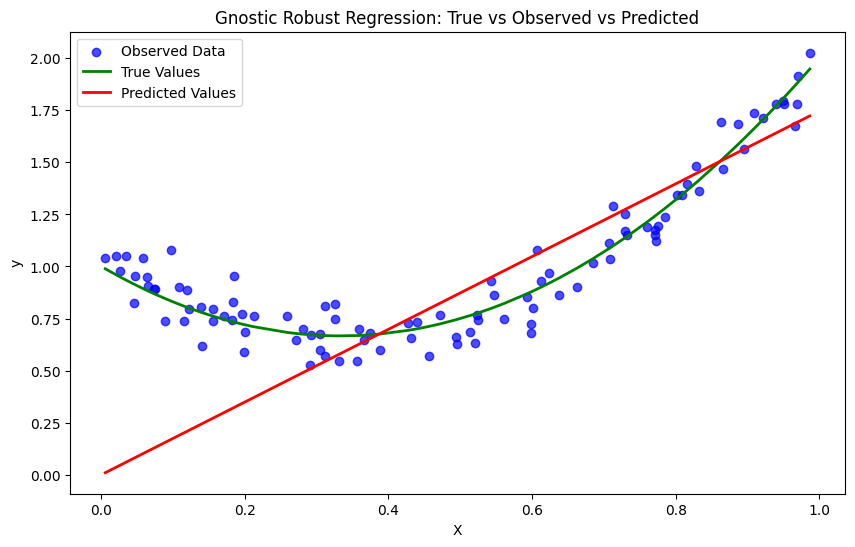

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
X = np.random.rand(100, 1)  # Single feature
y_true = 3 * X[:, 0]**2 - 2 * X[:, 0] + 1  # True quadratic function
y_observed = y_true + np.random.normal(0, 0.1, size=100)  # Add noise to create observed data

# Initialize and fit the model with degree 2 (quadratic regression)
model = GnosticRobustRegression(X, y_observed, criterion="E1", max_iter=100, tol=1e-6, degree=1, gc_history=True)
model.fit()

# Predict values
y_pred = model.predict(X)

# Sort the data by X values for proper line plotting
sorted_indices = np.argsort(X[:, 0])  # Sort by the first column of X
X_sorted = X[sorted_indices]
y_true_sorted = y_true[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot of observed data
plt.scatter(X, y_observed, label="Observed Data", color="blue", alpha=0.7)

# Plot true values (sorted)
plt.plot(X_sorted, y_true_sorted, label="True Values", color="green", linewidth=2)

# Plot predicted values (sorted)
plt.plot(X_sorted, y_pred_sorted, label="Predicted Values", color="red", linewidth=2)

# Add labels, title, and legend
plt.title("Gnostic Robust Regression: True vs Observed vs Predicted")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()

# Show the plot
plt.show()